<a href="https://colab.research.google.com/github/zoebatz/CAP6640_Project/blob/main/NLP_gpt_TC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import openai
import pandas as pd
import numpy as np
import os
import kagglehub

from google.colab import userdata

# print(openai.__version__)
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_NLP')

In [177]:
# import data from google drive
file_name = "data_tc1"

path = "/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/data/"+file_name+".csv"
data = pd.read_csv(path)
data.head()



,movie_id,text,genre,label
0,tt12783454,Elle Evans (Joey King) has finally completed h...,romance,0
1,tt1798632,A young girl tries to understand how she myste...,horror,1
2,tt9214832,"In 1800s England, a well meaning but selfish y...",comedy,2
3,tt8522006,Abby Holland (Kristen Stewart) and Harper Cald...,romance,0
4,tt21249656,Olga and Maks are 15 years apart. She is a suc...,romance,0


In [178]:
len(data)

1000

In [179]:
data.value_counts('label')

,count
label,
0,250
1,250
2,250
3,250


In [180]:
zero_shot = f""" """

one_shot = f"""
              Input: "Two strangers from different worlds cross paths and form an unexpected bond. As they navigate challenges and personal doubts, they must decide if taking a leap of faith is worth the risk."
              Output: Romance
              Input: "A quiet town is shaken when an ancient evil awakens, preying on those who dare to uncover its secrets. As the darkness spreads, a small group must fight to survive before they become its next victims."
              Output: Horror
              Input: "When a series of ridiculous misunderstandings spirals out of control, an unlikely group of misfits is forced to work together. Along the way, chaos ensues, friendships are tested, and laughter is inevitable."
              Output: Comedy
              Input: "A skilled operative is pulled back into a dangerous world after uncovering a high-stakes conspiracy. With time running out and enemies closing in, they must rely on their instincts to stop a catastrophic event."
              Output: Action
"""

three_shot = f"""
            Input: "A chance encounter leads to an undeniable spark, but timing and circumstances threaten to pull them apart. As fate keeps bringing them together, they must decide if love is worth the complications."
            Output: Romance
            Input: "Two longtime friends find their relationship shifting when unexpected feelings surface. Caught between fear of change and the promise of something more, they must figure out if love is worth the risk."
            Output: Romance
            Input: "A whirlwind adventure forces two opposites to rely on each other, revealing a connection neither of them saw coming. As their journey unfolds, they must confront their pasts to embrace what lies ahead."
            Output: Romance
            Input: "A group of travelers stumbles upon an abandoned town, only to realize they were meant to arrive. As they search for a way out, they uncover a chilling secret that refuses to let them leave."
            Output: Horror
            Input: "Strange occurrences begin plaguing a family after they move into their dream home. What starts as small, unexplainable events soon escalates into a terrifying battle for survival."
            Ouput: Horror
            Input: "A late-night dare leads a group of friends to an infamous, cursed location. When one of them disappears, they realize the legend is real—and they may be next."
            Output: Horror
            Input: "When a well-intentioned lie spirals out of control, one person finds themselves leading a double life. Juggling the chaos becomes increasingly difficult as the truth threatens to come crashing down."
            Output: Comedy
            Input: "A disastrous wedding weekend goes completely off the rails as secrets are revealed, plans unravel, and an unexpected guest shakes things up. Somehow, amidst the madness, love and laughter still find a way."
            Output: Comedy
            Input: "An underdog team of misfits is thrown together for a high-stakes competition they have no business entering. Against all odds (and their own ridiculous mistakes), they just might stand a chance."
            Output: Comedy
            Input: "A skilled thief is forced out of retirement for one last heist, but things go wrong when they realize they’ve been set up. Now, they must outwit their pursuers and uncover the truth before it’s too late."
            Output: Action
            Input: "When a deadly secret is exposed, a reluctant hero is thrust into a global chase against ruthless enemies. With the odds stacked against them, they must fight to stop a disaster before it’s too late."
            Output: Action
            Input: "A former agent with a troubled past is pulled back into action when their loved one is taken. As the clock ticks down, they’ll stop at nothing to bring them home—no matter the cost."
            Output: Action
"""


In [181]:
# text classification with GPT

def classify_text(text):
    try:
        # Call GPT-3.5 Turbo
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a classifier for movie genres. Given a story summary, decide which genre it belongs to out of these four explicitly: romance, horror, comedy, action. Respond only with 'romance', 'horror', 'comedy' or 'action' and no other words or symbols."},
                {"role": "user", "content": shot},
                {"role": "user", "content": text}
            ]
        )
        # Extract and return the response
        sentiment = response.choices[0].message.content.strip()
#       print(response.choices[0].message.content)
        return sentiment
    except Exception as e:
        return f"Error: {e}"

In [182]:
# adjust for desired prompt / model / data size
test_size = len(data)   # can adjust for smaller testing

function = classify_text
shot_name = "three_shot"      # change for zero / one / three shot
model_name = "gpt-3.5-turbo"  # change for different models

In [183]:

prediction = []

if shot_name == "one_shot":
  shot = one_shot
elif shot_name == "three_shot":
  shot = three_shot
else:
  shot = zero_shot



# text classification
def genre_classification(data):
  count = 0
  for i, texts in enumerate(data.text[:test_size]):
    result = function(texts)
    count += 1
    if count % 100 == 0:
      print(count)

#    print(data.text[i])

    # Convert result and data.genre[i] to lowercase for comparison
    result = result.lower()
    actual_genre = data.genre.iloc[i].lower()

#    print("\nresult: ", result)
#    print("label: ", data.genre[i])

    if result == 'romance':
      prediction.append('romance')

    elif result == 'horror':
      prediction.append('horror')

    elif result == 'comedy':
      prediction.append('comedy')

    elif result == 'action':
      prediction.append('action')

    else:
      # Handle unexpected results, e.g., by appending a default value
      print(f"Unexpected result for text at index {i}: {result}")
      prediction.append(result) # Append 0 as a default for unexpected results

def spam_classification(data):
  count = 0
  for i, texts in enumerate(data.text[:test_size]):
    result = function(texts)
    count += 1
    if count % 100 == 0:
      print(count)

    if result == 'spam':
      prediction.append(1)
    elif result == 'ham':
      prediction.append(0)
    else:
      # Handle unexpected results, e.g., by appending a default value
      print(f"Unexpected result for text at index {i}: {result}")
      prediction.append(0) # Append 0 as a default for unexpected results



In [184]:
genre_classification(data)


Unexpected result for text at index 18: fantasy
100
Unexpected result for text at index 114: drama
Unexpected result for text at index 120: drama
Unexpected result for text at index 195: mystery
200
Unexpected result for text at index 238: dark comedy
300
Unexpected result for text at index 303: drama
Unexpected result for text at index 346: war films often have elements of action, drama, or historical genres. however, based on the summaries provided, the story leans more towards the genre of **action**.
Unexpected result for text at index 347: drama
Unexpected result for text at index 352: drama
400
Unexpected result for text at index 444: drama
Unexpected result for text at index 457: adventure
500
Unexpected result for text at index 502: drama
Unexpected result for text at index 532: drama
Unexpected result for text at index 548: thriller
Unexpected result for text at index 550: thriller
Unexpected result for text at index 566: drama
Unexpected result for text at index 567: animatio

In [185]:
len(prediction)

1000

In [186]:
len(data)

1000

In [187]:
# copy predictions to pred_copy
pred_copy = prediction.copy()

In [201]:
prediction = pred_copy.copy()

In [202]:
# count unexpected predictions
count = 0
for i in range(len(prediction)):
  if prediction[i] != 'romance' and prediction[i] != 'horror' and prediction[i] != 'comedy' and prediction[i] != 'action':
    count += 1


print(count)

32


In [203]:
# combine count unexpected with options for handling

handle_option = 1 # 0 = change all to 0 / 1 = remove / 2 = manual switch
indices_to_remove = []
count = 0

for i, pred in enumerate(prediction):
    if pred not in ['romance', 'horror', 'comedy', 'action']:
        count += 1
        if handle_option == 0:
            prediction[i] = 'romance'
        elif handle_option == 1:
            indices_to_remove.append(i)


#print(indices_to_remove)

if handle_option == 1:
    # Remove rows from data and prediction outside the loop
    data.drop(data.index[indices_to_remove], inplace=True)
    prediction = [pred for i, pred in enumerate(prediction) if i not in indices_to_remove]

print(count)


32


In [204]:
len(prediction)

968

In [205]:
data.genre.value_counts()

,count
genre,
horror,249
romance,247
action,245
comedy,227


In [206]:
file_name

'data_tc1'

In [207]:
shot_name


'three_shot'

In [208]:
handle_option

1

In [209]:
# view metrics and save
def view_and_save_metrics(data, predicted_classes):
  accuracy = accuracy_score(data.tolist(), predicted_classes)
  precision = precision_score(data.tolist(), predicted_classes, average='weighted')
  recall = recall_score(data.tolist(), predicted_classes, average='weighted')
  f1 = f1_score(data.tolist(), predicted_classes, average='weighted')
  conf_matrix = confusion_matrix(data.tolist(), predicted_classes)
  #roc_auc = roc_auc_score(data.tolist(), predicted_classes)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)
  #print("ROC AUC Score:", roc_auc)

  metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "confusion_matrix": conf_matrix,
  #    "roc_auc_score": roc_auc,
      "model_name": model_name,
      "dataset": file_name
  }

  # save metrics to csv file
  metrics_df = pd.DataFrame([metrics])
  metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/metrics_'+model_name+'_'+file_name+'_'+shot_name+'_'+str(handle_option)+'.csv', index=False)



In [210]:
view_and_save_metrics(data.genre, prediction)

Accuracy: 0.8171487603305785
Precision: 0.8229182360332742
Recall: 0.8171487603305785
F1 Score: 0.8093781641130321
Confusion Matrix:
 [[228   6   9   2]
 [ 36 123  19  49]
 [ 17   2 221   9]
 [ 11  13   4 219]]


In [211]:
data.genre.value_counts()

,count
genre,
horror,249
romance,247
action,245
comedy,227


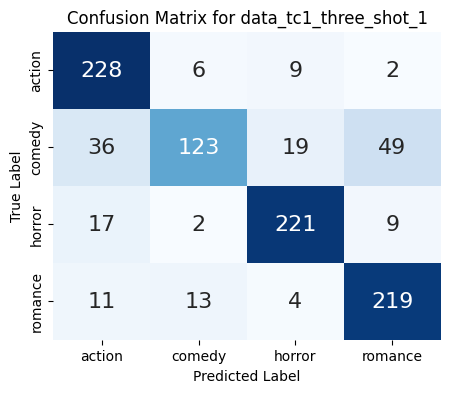

In [212]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.genre, prediction)

# Define class labels
labels = ["action", "comedy", "horror", "romance"]

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels)

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for {file_name}_{shot_name}_{handle_option}")
plt.savefig(f"/content/drive/MyDrive/Colab Notebooks/CAP6640_NLP/metrics/text_classification/confusion_matrix_{file_name}_{shot_name}_{handle_option}.png")
plt.show()
